In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer2013/test/surprise/PublicTest_78686873.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_58522921.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_83796714.jpg
/kaggle/input/fer2013/test/surprise/PublicTest_84428313.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_87978901.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_90978621.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_27580582.jpg
/kaggle/input/fer2013/test/surprise/PublicTest_15760011.jpg
/kaggle/input/fer2013/test/surprise/PublicTest_49739228.jpg
/kaggle/input/fer2013/test/surprise/PublicTest_5351857.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_56096676.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_71692098.jpg
/kaggle/input/fer2013/test/surprise/PublicTest_64532931.jpg
/kaggle/input/fer2013/test/surprise/PublicTest_17886908.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_21410542.jpg
/kaggle/input/fer2013/test/surprise/PrivateTest_68745885.jpg
/kaggle/input/fer2013/test/surpr

### Import Necessary Libraries

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Prepare Data Generators for Image Processing

In [19]:
img_size = (48, 48)
batch_size = 64
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

train_dg = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = train_dg.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_dg.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_dg = ImageDataGenerator(rescale=1./255)

test_generator = test_dg.flow_from_directory(
    test_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 25841 images belonging to 7 classes.
Found 2868 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Visualize Sample Image with Labels

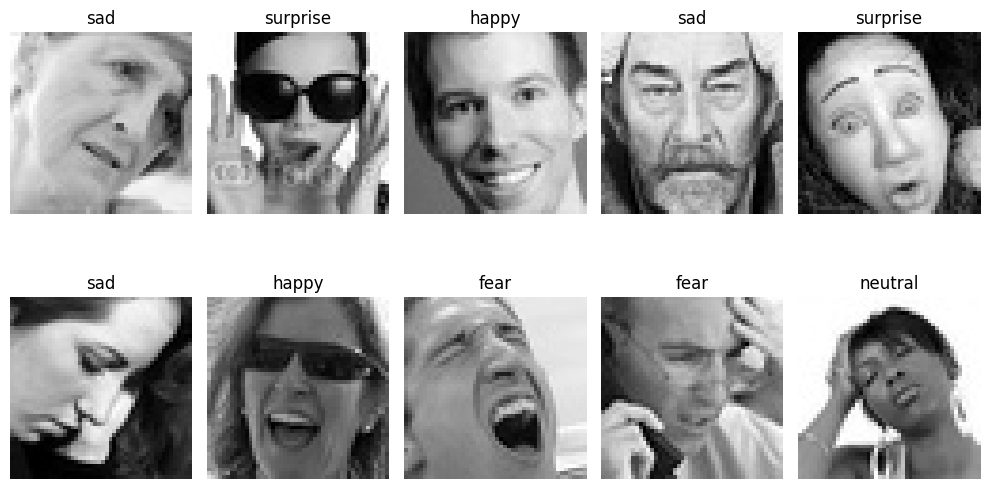

In [20]:
class_names = list(train_generator.class_indices.keys())

def show_samples(generator):
    images, labels = next(generator)
    plt.figure(figsize=(10, 6))
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].reshape(48, 48), cmap="gray")
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    plt.tight_layout()
    plt.show()
#
show_samples(train_generator)

### Data Augmentation - Achieve Image Generilization and Reduce Overfitting

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (48, 48)
batch_size = 64

train_dg = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_dg = ImageDataGenerator(rescale=1./255)

In [22]:
train_generator = train_dg.flow_from_directory(
    '/kaggle/input/fer2013/train',
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator = train_dg.flow_from_directory(
    '/kaggle/input/fer2013/train',
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

test_generator = test_dg.flow_from_directory(
    '/kaggle/input/fer2013/test',
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Training Callbacks: Training Optimization & Overfitting Preventation

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     
    factor=0.2,            
    patience=4,            
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

### Train Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

input_shape = (48, 48, 1)

model = Sequential()

# Block 1
model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Fully Connected
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,510,215 (13.39 MB)

 Trainable params: 3,507,911 (13.38 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [25]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

In [27]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=55,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/55
359/359 ━━━━━━━━━━━━━━━━━━━━ 55s 119ms/step - accuracy: 0.2173 - loss: 2.3568 - val_accuracy: 0.2763 - val_loss: 1.7828 - learning_rate: 0.0010
Epoch 2/55
359/359 ━━━━━━━━━━━━━━━━━━━━ 34s 94ms/step - accuracy: 0.3353 - loss: 1.7383 - val_accuracy: 0.3921 - val_loss: 1.6094 - learning_rate: 0.0010
Epoch 3/55
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 99ms/step - accuracy: 0.4174 - loss: 1.5092 - val_accuracy: 0.4452 - val_loss: 1.4534 - learning_rate: 0.0010
Epoch 4/55
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - accuracy: 0.4702 - loss: 1.3773 - val_accuracy: 0.5025 - val_loss: 1.2988 - learning_rate: 0.0010
Epoch 5/55
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 99ms/step - accuracy: 0.5106 - loss: 1.2780 - val_accuracy: 0.5010 - val_loss: 1.2935 - learning_rate: 0.0010
Epoch 6/55
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 99ms/step - accuracy: 0.5329 - loss: 1.2239 - val_accuracy: 0.5334 - val_loss: 1.2391 - learning_rate: 0.0010
Epoch 7/55
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.5529 - 

### Visualizing Training Performance

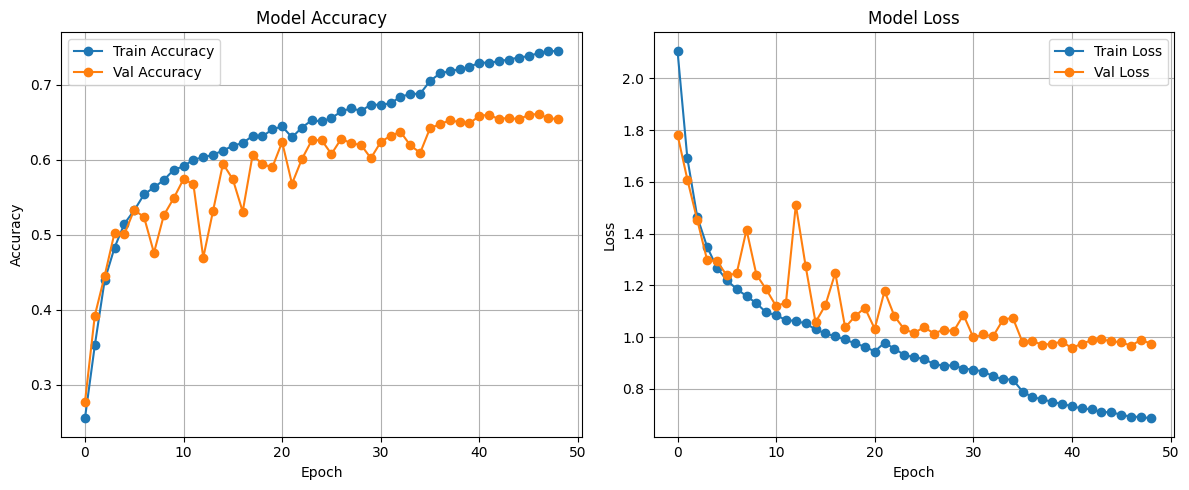

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [29]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.6393 - loss: 1.0472
Test Accuracy: 0.6659
Test Loss: 0.9689


### Predictions Made

In [30]:
import numpy as np

pred_probs = model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step


### 70 Predictions at Random

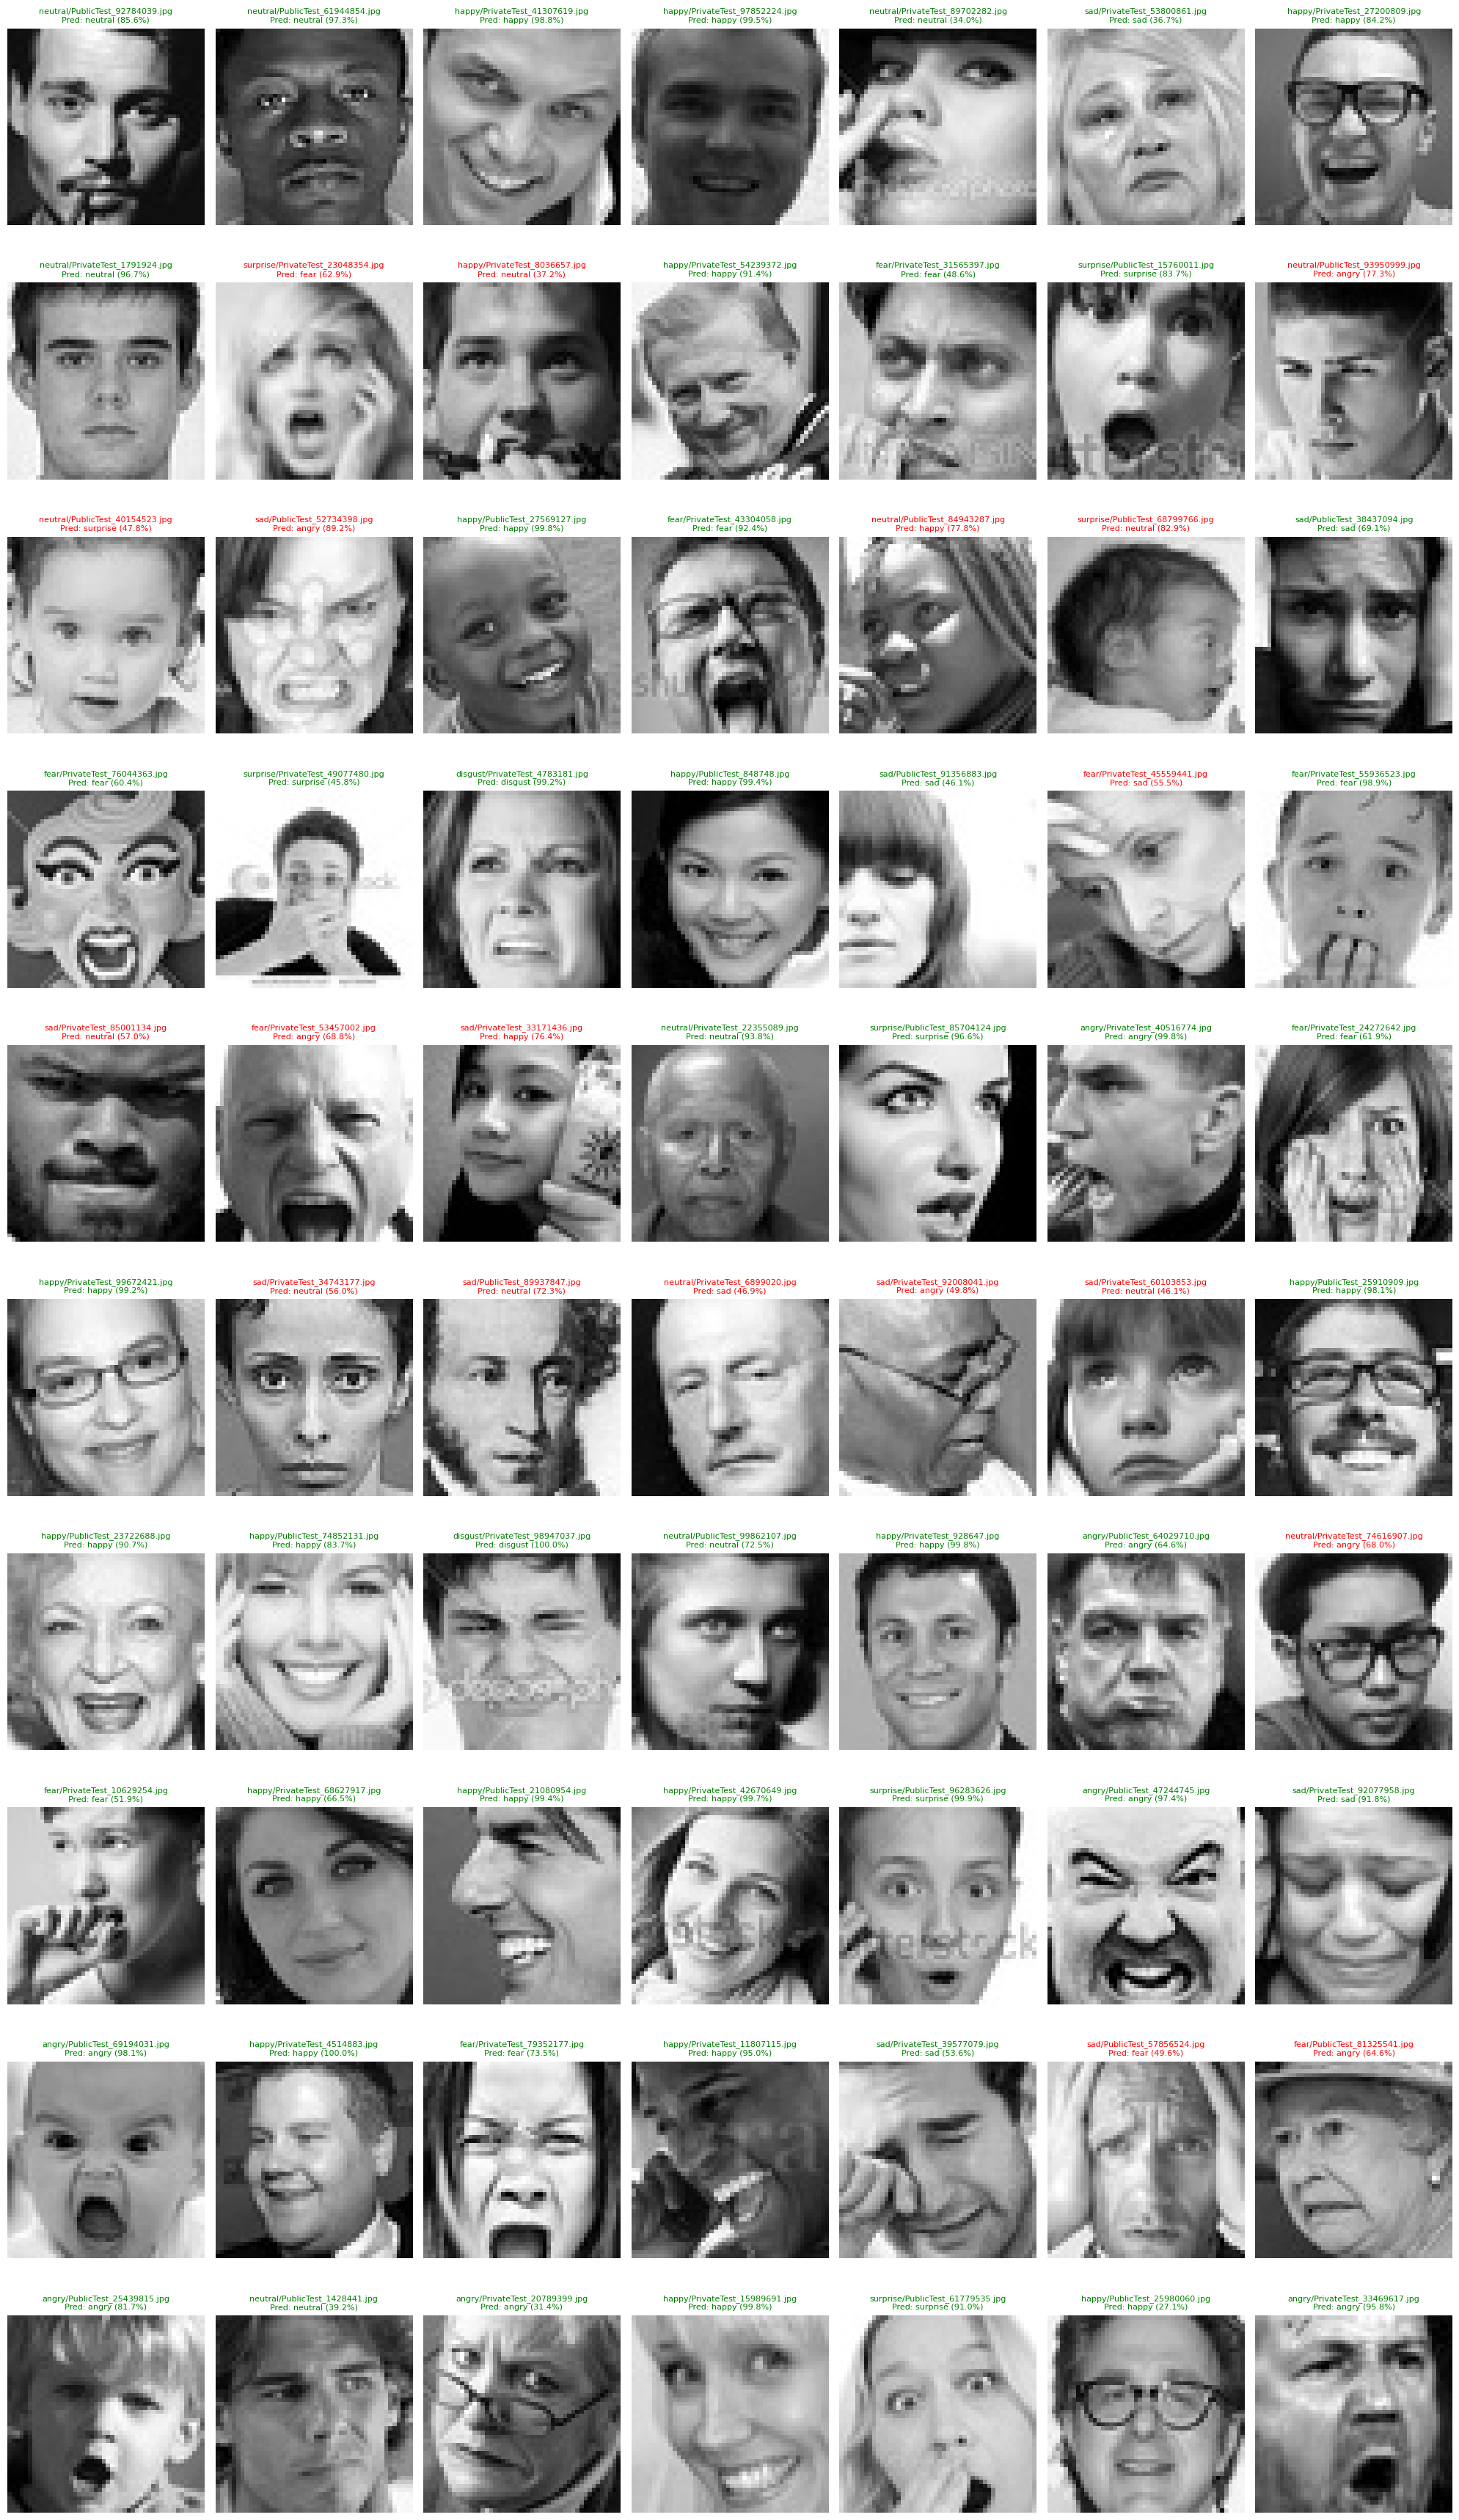

 Correctly Predicted: 51 / 70


In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os

filenames = test_generator.filepaths  

plt.figure(figsize=(20, 35)) 
correct_count = 0 
for i in range(70):
    index = np.random.randint(0, len(filenames))
    img_path = filenames[index]
    img = plt.imread(img_path)

    class_name = os.path.basename(os.path.dirname(img_path)) 
    filename = os.path.basename(img_path)

    true_label = class_labels[true_classes[index]]
    pred_label = class_labels[pred_classes[index]]
    confidence = np.max(pred_probs[index]) * 100

    if pred_label == true_label:
        correct_count += 1

    plt.subplot(10, 7, i + 1) 
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    title_color = 'green' if pred_label == true_label else 'red'
    plt.title(f'{class_name}/{filename}\nPred: {pred_label} ({confidence:.1f}%)',
              fontsize=8, color=title_color)

plt.tight_layout()
plt.show()

print(f' Correctly Predicted: {correct_count} / 70')

### Predicting 200 Random Images

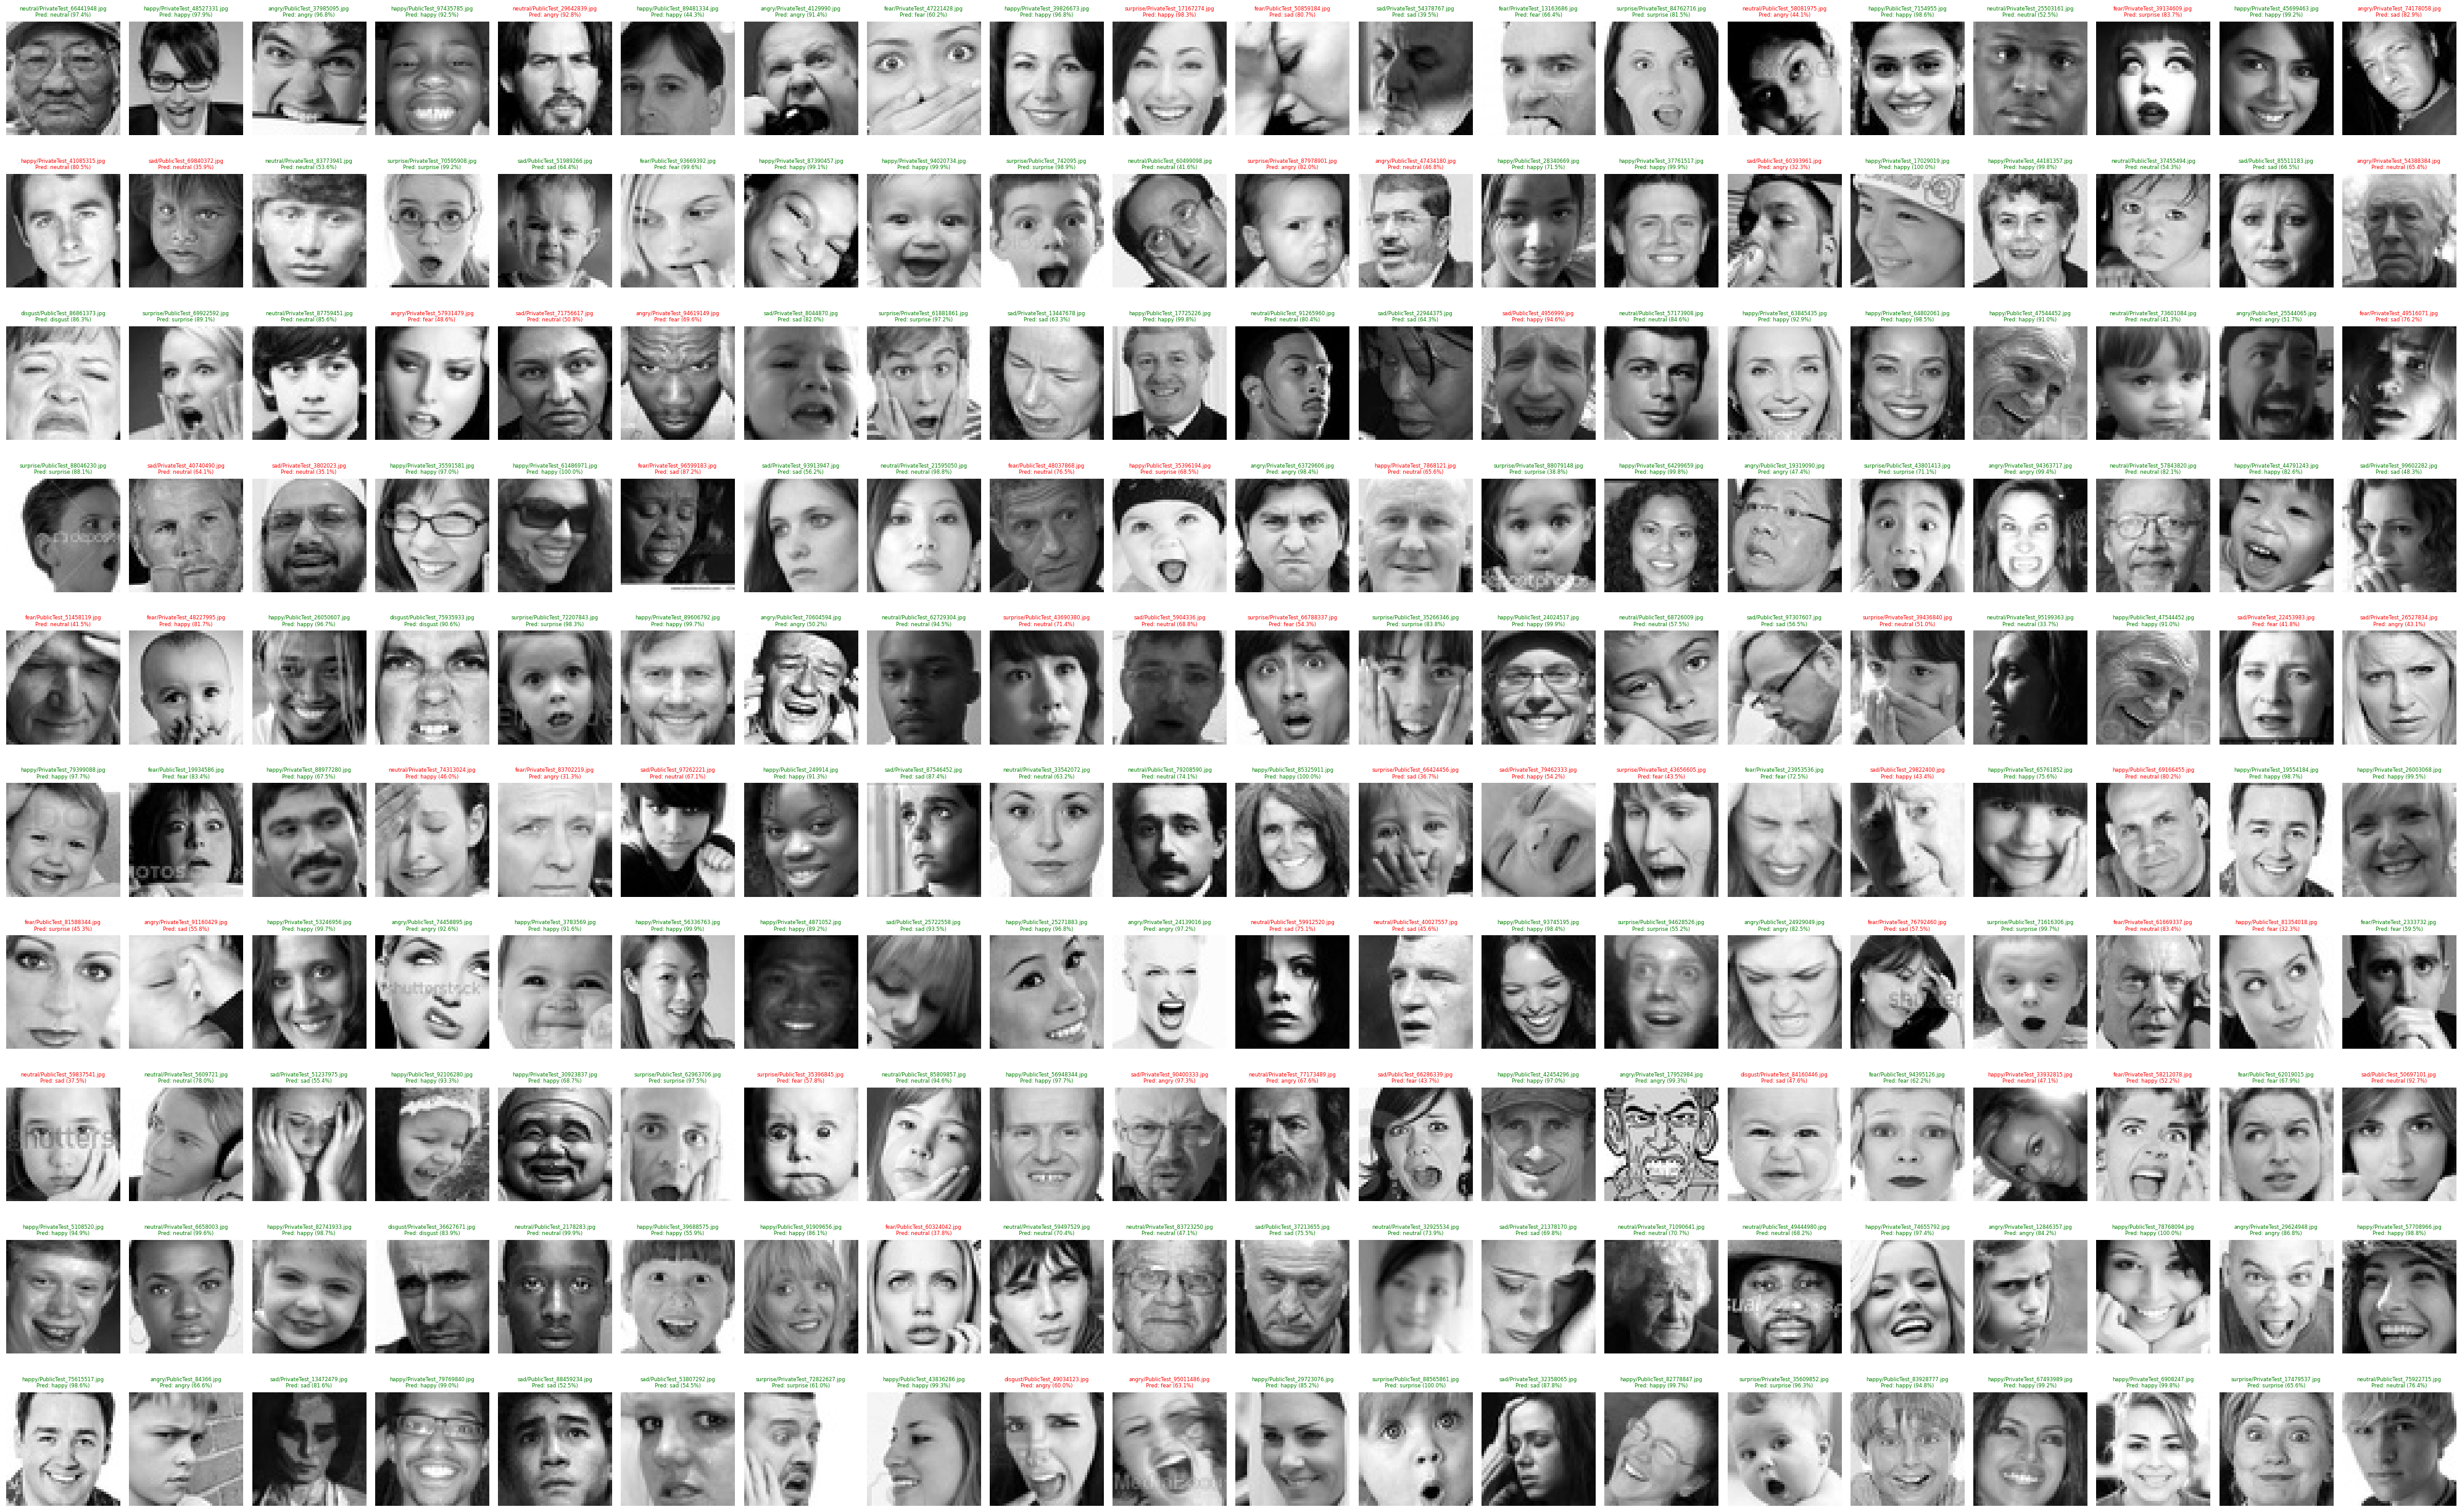

Correctly Predicted: 142 / 200


In [40]:
import matplotlib.pyplot as plt
import numpy as np
import os

filenames = test_generator.filepaths  
plt.figure(figsize=(40, 25))  

correct_count = 0 

for i in range(200):
    index = np.random.randint(0, len(filenames))
    img_path = filenames[index]
    img = plt.imread(img_path)

    class_name = os.path.basename(os.path.dirname(img_path)) 
    filename = os.path.basename(img_path)

    true_label = class_labels[true_classes[index]]
    pred_label = class_labels[pred_classes[index]]
    confidence = np.max(pred_probs[index]) * 100

    if pred_label == true_label:
        correct_count += 1

    plt.subplot(10, 20, i + 1)  
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    title_color = 'green' if pred_label == true_label else 'red'
    plt.title(f'{class_name}/{filename}\nPred: {pred_label} ({confidence:.1f}%)',
              fontsize=6, color=title_color)

plt.tight_layout()
plt.show()

#  Final summary
print(f'Correctly Predicted: {correct_count} / 200')